### Project Settings

In [1]:
import os
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn2
import math
import seaborn as sns


pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn-whitegrid')
# plt.rcParams['font.size'] = '22'
# plt.rcParams['axes.titlesize'] = '22'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d'

## Data Preparation

### Given Files

In [2]:
daily_files = os.listdir(os.path.join(os.getcwd(), 'Rakuten_Ranking', 'daily'))
weekly_files = os.listdir(os.path.join(os.getcwd(), 'Rakuten_Ranking', 'weekly'))
daily_scrape_dates = [re.sub('[^0-9]', '', x) for x in daily_files]
weekly_scrape_dates = [re.sub('[a-zA-Z.]', '', x).split("_")[3] for x in weekly_files]

print('FILE DATA:')
print(f'Count of Daily Files: {len(daily_files)}')
print(f'Count of Weekly Files: {len(weekly_files)}')
print(f'Sample daily scrape filename: {daily_files[0]}')
print(f'Sample weekly scrape filename: {daily_files[0]}')
print(f'Daily files scraped from: {daily_scrape_dates[0]} to {daily_scrape_dates[-1]}')
print(f'Weekly files scraped from: {weekly_scrape_dates[0]} to {weekly_scrape_dates[-1]}')

FILE DATA:
Count of Daily Files: 23
Count of Weekly Files: 13
Sample daily scrape filename: RAKUTEN_RANKING_20220823_daily.xlsm
Sample weekly scrape filename: RAKUTEN_RANKING_20220823_daily.xlsm
Daily files scraped from: 20220823 to 20221102
Weekly files scraped from: 20220810 to 20221102


### Data Loading and Cleaning

In [3]:
def basic_text_clean(text):
    '''
    methods: uppercase, strip whitespace in front and back of text, remove text between 【】
    replace commas with space, remove newline, remove carriage return character, remove duplicated whitespace
    '''
    text = text.lower()
    text = text.strip()
    text = re.sub(r'【.*?】', ' ', text)
    text = re.sub(',',' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = re.sub('\s+', ' ', text)

    return text


def combine_files(filepaths, periods, picklename):
    combined_df = pd.DataFrame()

    for filepath, period in zip(filepaths, periods):
        df = pd.read_excel(filepath, sheet_name='DATAIN')
        df['date_scraped'] = pd.to_datetime(period)
        df['date_scraped'] = pd.to_datetime(df['date_scraped']).dt.date
        combined_df = pd.concat([combined_df, df]).reset_index(drop=True)

    for col in combined_df.columns[0:5]:
        combined_df[col] = combined_df[col].apply(lambda x: basic_text_clean(x))

    combined_df = combined_df.rename(columns={
        '順位':'rank',
        'カテゴリ':'category',
        '店舗':'store',
        '商品名':'product_name',
        '価格':'price'
    })
    
    combined_df['rank'] = combined_df['rank'].str.replace('位', '').astype('category')
    combined_df.to_pickle(picklename)


daily_filepaths = [os.path.join(os.getcwd(), 'Rakuten_Ranking', 'daily', fname) for fname in daily_files]
weekly_filepaths = [os.path.join(os.getcwd(), 'Rakuten_Ranking', 'weekly', fname) for fname in weekly_files]

# combine_files(daily_filepaths, daily_scrape_dates, 'daily.pkl')
# combine_files(weekly_filepaths, weekly_scrape_dates, 'weekly.pkl')

### Translate and encode data

In [4]:
def translate_decode(df_daily, df_weekly):
    categories = {
    'タイヤ':'tire',
    'サマータイヤ':'summer tire',
    'スタッドレスタイヤ':'studless tire',
    'オールシーズンタイヤ':'all-season tire',
    'エンジンオイル':'engine oil',
    'バッテリー本体':'battery body',
    'コンタクトレンズ・ケア用品':'contact lens care products',
    'ソフトコンタクトレンズ':'soft contact lens',
    'カラコン・サークルレンズ':'color contact lens / circle lens',
    'ハードコンタクトレンズ':'hard contact lens',
    '洗浄・保存液':'washing / preserving solution'
}   

    df_daily['category'] = df_daily['category'].replace(categories)
    df_weekly['category'] = df_weekly['category'].replace(categories)

    le = LabelEncoder()
    items_to_encode = pd.concat([df_daily, df_weekly])['product_name'].reset_index(drop=True)
    le.fit(items_to_encode)

    df_daily['unique_product_code'] = le.transform(df_daily['product_name'])
    df_weekly['unique_product_code'] = le.transform(df_weekly['product_name'])

    df_daily.to_pickle('daily.pkl')
    df_weekly.to_pickle('weekly.pkl')


df_daily = pd.read_pickle('daily.pkl')
df_weekly = pd.read_pickle('weekly.pkl')
# translate_decode()

## Data Exploration

#### 1. What is the data made of?

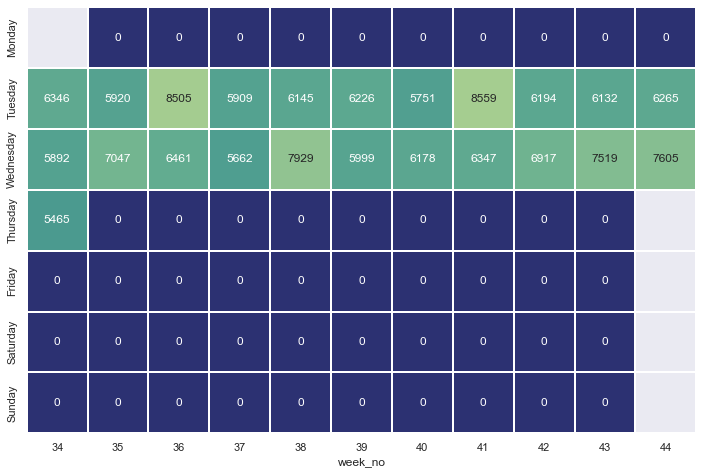

In [5]:
# group by date scraped
df_daily_samples = df_daily[['date_scraped', 'unique_product_code']].set_index('date_scraped')
df_daily_samples.index = pd.to_datetime(df_daily_samples.index)
df_daily_samples = df_daily_samples.resample('1D').count()

# get week_number
df_daily_samples['week_no'] = df_daily_samples.index.isocalendar().week

# # get weekday
df_daily_samples.index = df_daily_samples.index.dayofweek
df_daily_samples = df_daily_samples.pivot(columns='week_no',values='unique_product_code')
df_daily_samples = df_daily_samples.reset_index(drop=True)

sns.set(rc={"figure.figsize":(12,18)})
sns.heatmap(
    df_daily_samples,
    cbar=False, 
    cmap='crest_r', 
    square=True, 
    annot=True, 
    linewidth=2.,
    fmt=".0f",
    yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.show()

In [6]:
def plot_summary(df_summary, label='Daily'):

    df_summary = pd.pivot(df_summary, index='date_scraped', columns=['category'], values=['store', 'unique_product_code', 'price'])

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,18))
    fig.delaxes(axs[1,1])

    # plot store count
    df_summary['store'].plot.bar(
        title=f'Number of Unique Stores per Category ({label})',
        stacked=True,
        ax=axs[0,0], 
        legend=False, 
        colormap='tab20c',
        rot=45,
        xlabel=''
    )

    #plot unique_product code count
    df_summary['unique_product_code'].plot.bar(
        title=f'Number of Unique Products per Category ({label})',
        stacked=True,
        ax=axs[1,0], 
        legend=False, 
        colormap='tab20c',
        rot=45,
        xlabel=''
    )

    # plot mean price
    df_summary['price'].plot(
        kind='box',
        title='Average Price per Category',
        ax=axs[0,1],
        rot=45
    )
        
    lines = []
    labels = []
    for ax in fig.axes[:1]:
        line, label = ax.get_legend_handles_labels()
        lines.extend(line)
        labels.extend(label)

    fig.subplots_adjust(wspace=0.1)
    fig.legend(lines, labels, loc=10, bbox_to_anchor=(0.45, 0.05, 0.5, 0.5))
    plt.show()

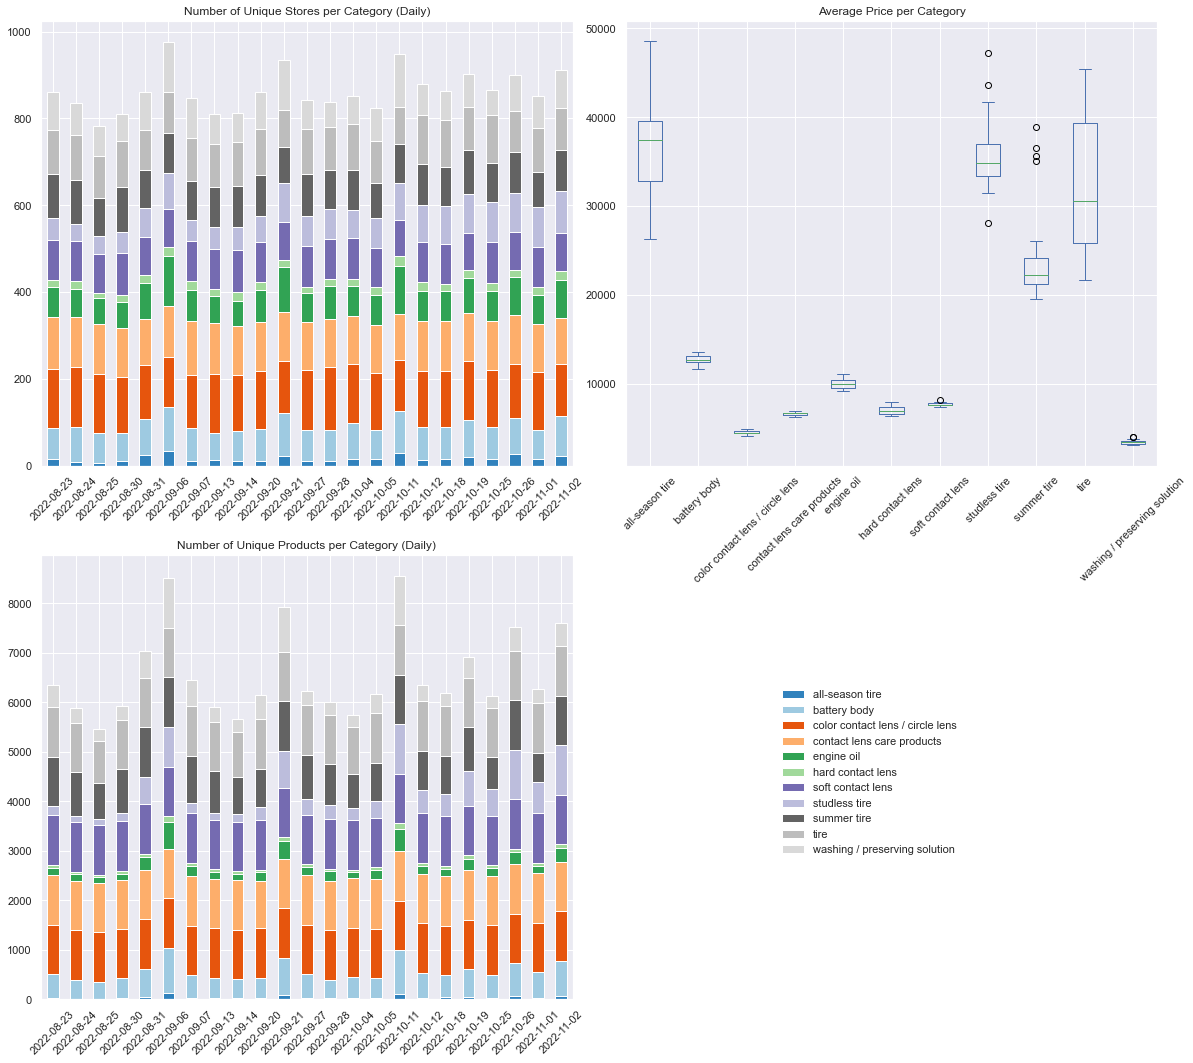

In [7]:
df_daily_summary = df_daily.groupby(['category','date_scraped']).agg({
    'store':pd.Series.nunique,
    'price':pd.Series.mean,
    'unique_product_code':pd.Series.count
}).reset_index()

plot_summary(df_summary=df_daily_summary, label='Daily')

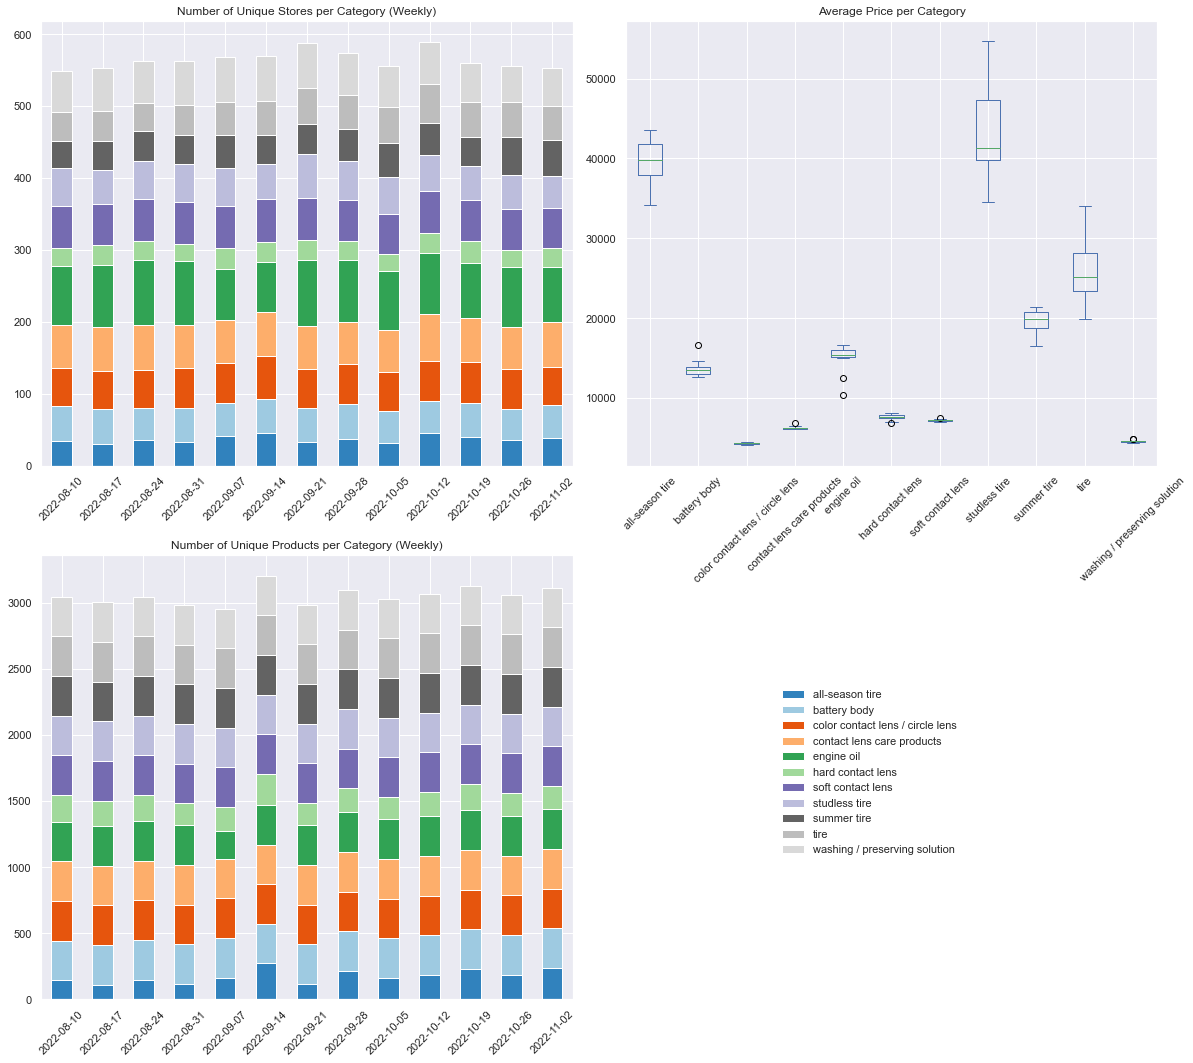

In [8]:
df_weekly_summary = df_weekly.groupby(['category','date_scraped']).agg({
    'store':pd.Series.nunique,
    'price':pd.Series.mean,
    'unique_product_code':pd.Series.count
}).reset_index()

plot_summary(df_summary=df_weekly_summary, label='Weekly')

#### 2. How many ranked products are retained in the ranking list by next day? 

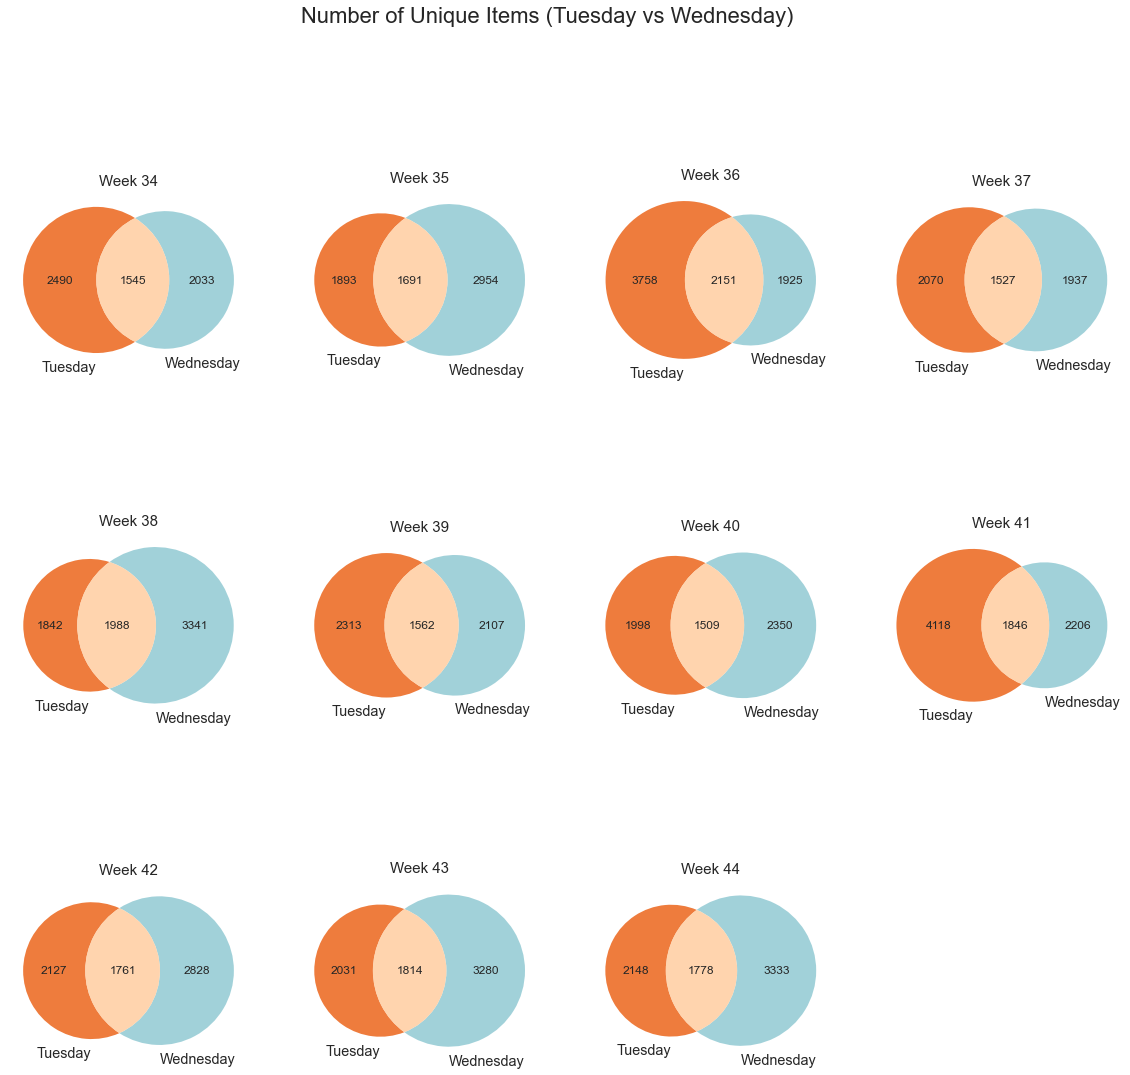

In [9]:
def plot_intersections(input_df, title):

    df_period_samples = input_df[['date_scraped', 'unique_product_code']].set_index('date_scraped').reset_index()
    df_period_samples['day_name'] = pd.to_datetime(df_period_samples['date_scraped']).dt.day_name()
    df_period_samples['week_no'] = pd.to_datetime(df_period_samples['date_scraped']).dt.isocalendar().week

    study_periods = df_period_samples['week_no'].unique()
    nrows =int(math.floor(len(study_periods)/4)+1)

    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(20,18))
    fig.suptitle(title,fontsize = 22)
    fig.delaxes(fig.axes[-1])
    colors = ['#EA5B0C', '#8AC6D0']

    for week_no, ax in zip(study_periods, fig.axes):
        tues_items = df_period_samples[(df_period_samples['week_no']==week_no) & (df_period_samples['day_name']=='Tuesday')]['unique_product_code']
        wed_items = df_period_samples[(df_period_samples['week_no']==week_no) & (df_period_samples['day_name']=='Wednesday')]['unique_product_code']
        venn2([set(tues_items), set(wed_items)], ('Tuesday', 'Wednesday'), ax=ax, set_colors=colors, alpha=0.8)
        ax.set_title(f'Week {week_no}', fontsize = 15)


plot_intersections(df_daily, 'Number of Unique Items (Tuesday vs Wednesday)')

#### 3. How far does one product move in ranking by the next day?

#### 4. How many daily ranked products make it into the weekly rankings?

#### 5. How long do products stay within the ranking system?

#### 6. Are there stores that make the ranking list more than once (different products)? 

#### 7. How many stores make the ranking list more than one week?

#### 8. How long do consistently ranking stores make the list?

#### 9. Does price factor in when it comes to ranking?

#### 10. How many of the ranked items are sold in sets?